### Задача 
- cкачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
- обучить word2vec на фразах персонажей
- визуаилизировать embeddings по самым частотным словам (top 1000)
- найти самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home
- построить классификатор bart/lisa с использованием этих эмбеддингов

In [1]:
from gensim.models import Word2Vec, KeyedVectors
import multiprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### 1. Импорт и предобработка данных

In [12]:
path_to_file = 'simpsons_script_lines.csv'

# Список колонок для чтения
act_columns = ["raw_character_text", "spoken_words"]

# Чтение файла CSV с предобработкой
data = pd.read_csv(
    path_to_file, 
    usecols=act_columns,
    on_bad_lines='skip'  # Добавлено для обработки ошибок в строках
)
data = data.dropna()  # Удаление строк с отсутствующими значениями
data = data.reset_index(drop=True)  # Сброс индекса
data = data.drop_duplicates()  # Удаление дубликатов

# Вывод первых нескольких строк обработанных данных
data

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
132105,Miss Hoover,I'm back.
132106,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
132107,Miss Hoover,Psy-cho-so-ma-tic.
132108,Ralph Wiggum,Does that mean you were crazy?


In [13]:
# чистка текста от знаков препинания/ приведение книжнему регистру

sentense_list = [re.sub(r"[-()\"#/@;:$!<>{}=~|.?,]", "", str(x)) 
                for x in data['spoken_words']]
sentense_list = [x.lower() for x in sentense_list]

In [14]:
# приведение текста реплик к формату списка слов

sentense_corpus           = [x.split() for x in sentense_list]
data['spoken_words_corp'] = sentense_corpus
data.head()

,raw_character_text,spoken_words,spoken_words_corp
0,Miss Hoover,"No, actually, it was a little of both. Sometim...","[no, actually, it, was, a, little, of, both, s..."
1,Lisa Simpson,Where's Mr. Bergstrom?,"[where's, mr, bergstrom]"
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,"[i, don't, know, although, i'd, sure, like, to..."
3,Lisa Simpson,That life is worth living.,"[that, life, is, worth, living]"
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,"[the, polls, will, be, open, from, now, until,..."


In [15]:
#  Классификатор реплик:  Барт / Лиза / Прочие 

data.loc[data.raw_character_text == 'Lisa Simpson', 'class_L_B']  = 1
data.loc[data.raw_character_text == 'Bart Simpson', 'class_L_B']  = 2
data['class_L_B'] = data['class_L_B'].fillna(0)
data['class_L_B'].value_counts()

class_L_B
0.0    104651
2.0     12088
1.0     10156
Name: count, dtype: int64

In [16]:
# максимальная длина реплик ключевых персонажей

data['data_len'] = [len(i) for i in data.spoken_words_corp]
data_pt = pd.pivot_table(data, values = 'data_len', index = 'raw_character_text', 
                         aggfunc = 'max').reset_index()
data_pt[(data_pt.raw_character_text =='Lisa Simpson')|
        (data_pt.raw_character_text =='Bart Simpson')]

,raw_character_text,data_len
602,Bart Simpson,73
3315,Lisa Simpson,75


In [17]:
# Если длина реплик ключевых персонажей не более 75 слов / 
# ограничим на этом пороге исследование

data['spoken_words_corp'] = [i[:75] for i in data['spoken_words_corp']]


In [18]:
data.head(1)

,raw_character_text,spoken_words,spoken_words_corp,class_L_B,data_len
0,Miss Hoover,"No, actually, it was a little of both. Sometim...","[no, actually, it, was, a, little, of, both, s...",0.0,31


In [19]:
data.iloc[:,[-2,-3]].head()

,class_L_B,spoken_words_corp
0,0.0,"[no, actually, it, was, a, little, of, both, s..."
1,1.0,"[where's, mr, bergstrom]"
2,0.0,"[i, don't, know, although, i'd, sure, like, to..."
3,1.0,"[that, life, is, worth, living]"
4,0.0,"[the, polls, will, be, open, from, now, until,..."


In [20]:
sents = data.spoken_words_corp.tolist()
labels = data.class_L_B.values.tolist()

### 2. Обучение Word2Vec  /  Визуализация по топ - 1000 самых частотных слов

### 2.1.  Мeтод 1 / PCA

In [21]:
model = Word2Vec(sents, min_count=1)

In [22]:
word_freq = defaultdict(int)
for sent in sentense_corpus:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

46878

In [23]:
top_1000 = sorted(word_freq, key=word_freq.get, reverse=True)[:1000]

X = model.wv[top_1000]

pca = PCA(n_components=2)
res = pca.fit_transform(X)

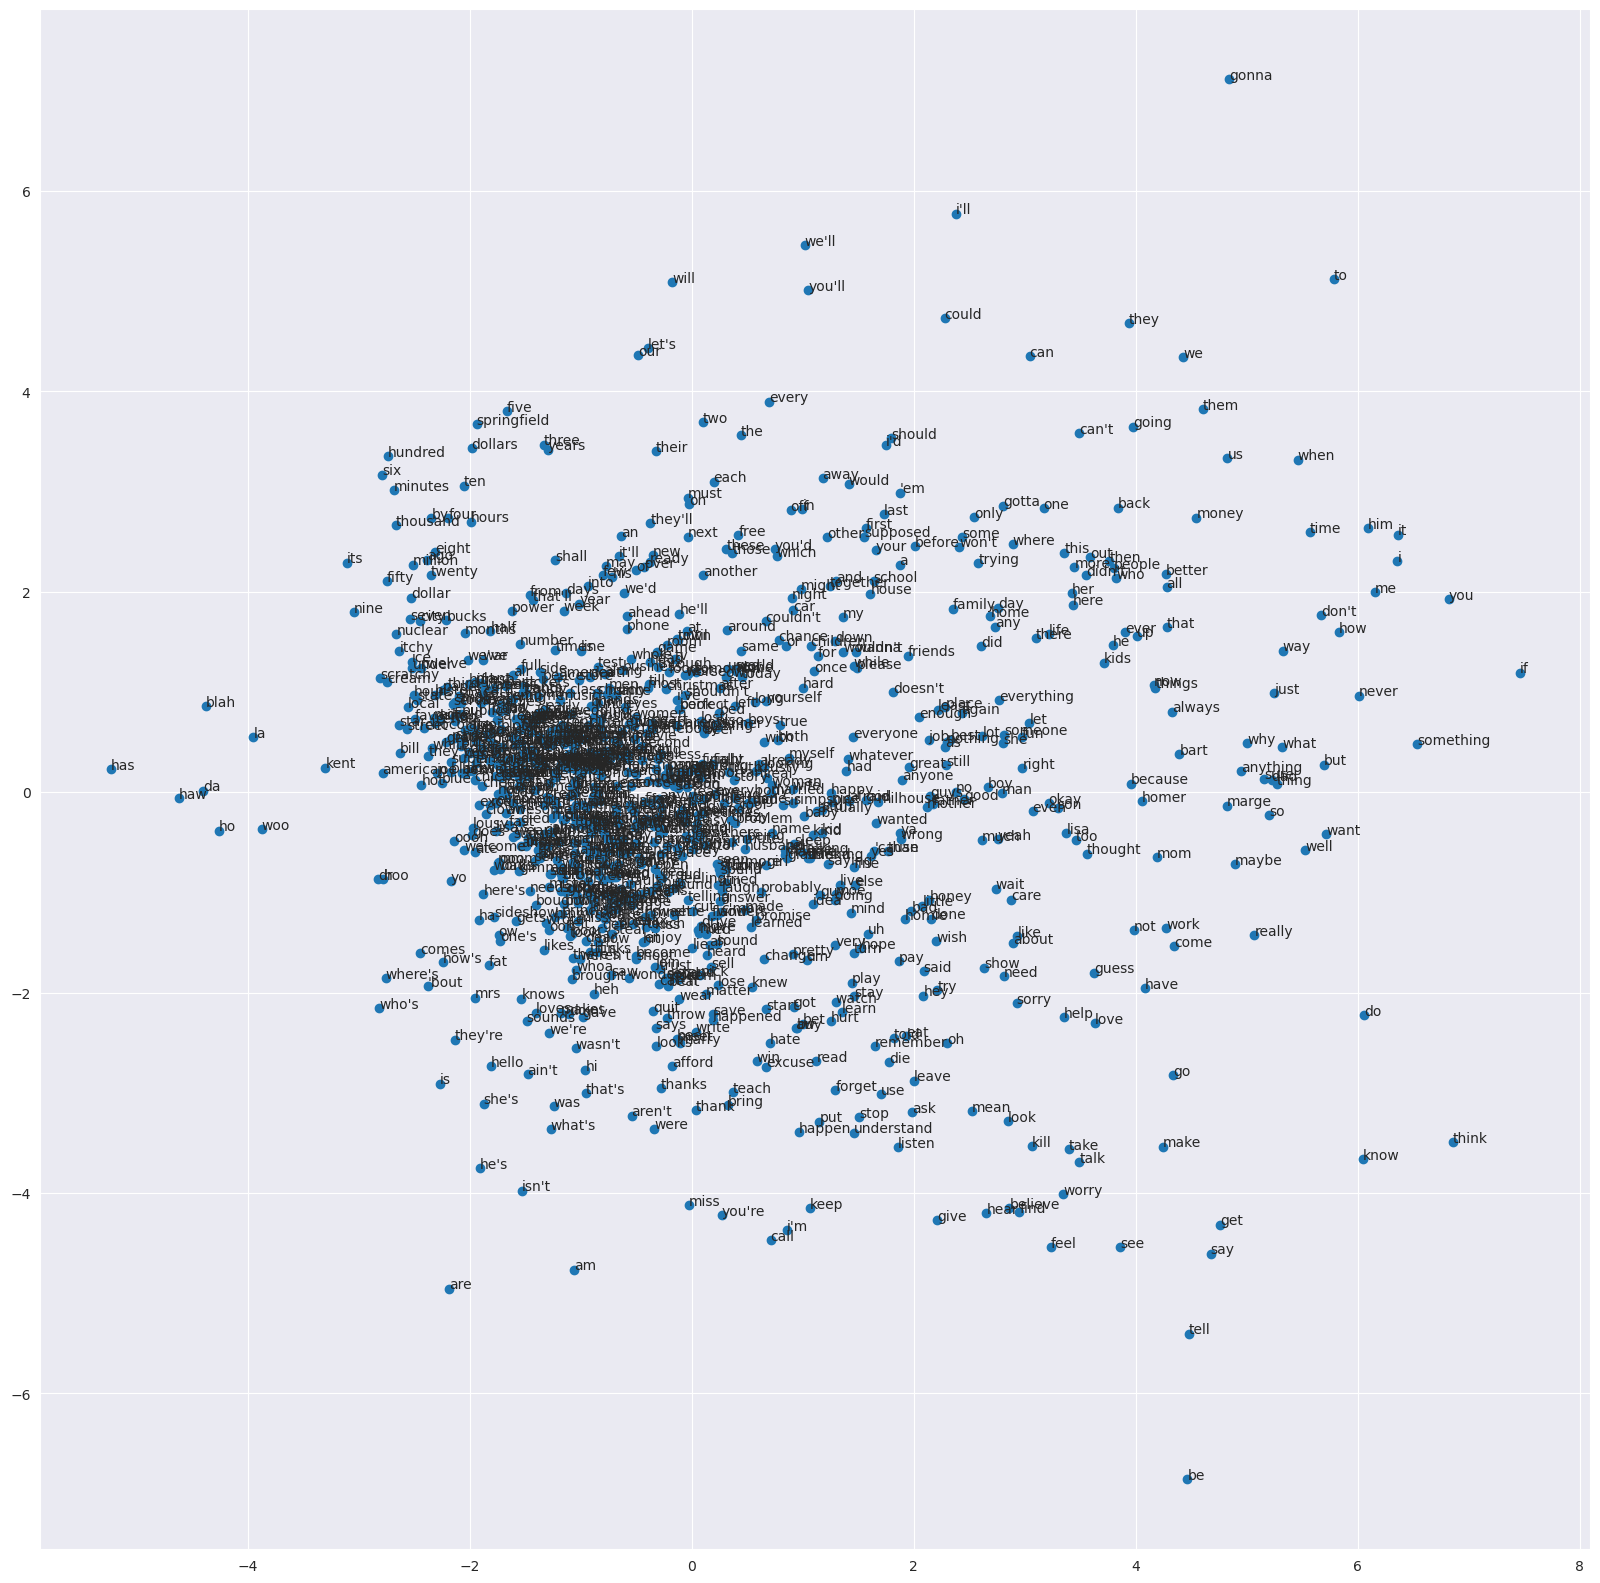

In [24]:
plt.scatter(res[:,0], res[:,1])
for i, word in enumerate(top_1000):
	  plt.annotate(word, xy=(res[i, 0], res[i, 1]))
plt.gcf().set_size_inches(20, 20)

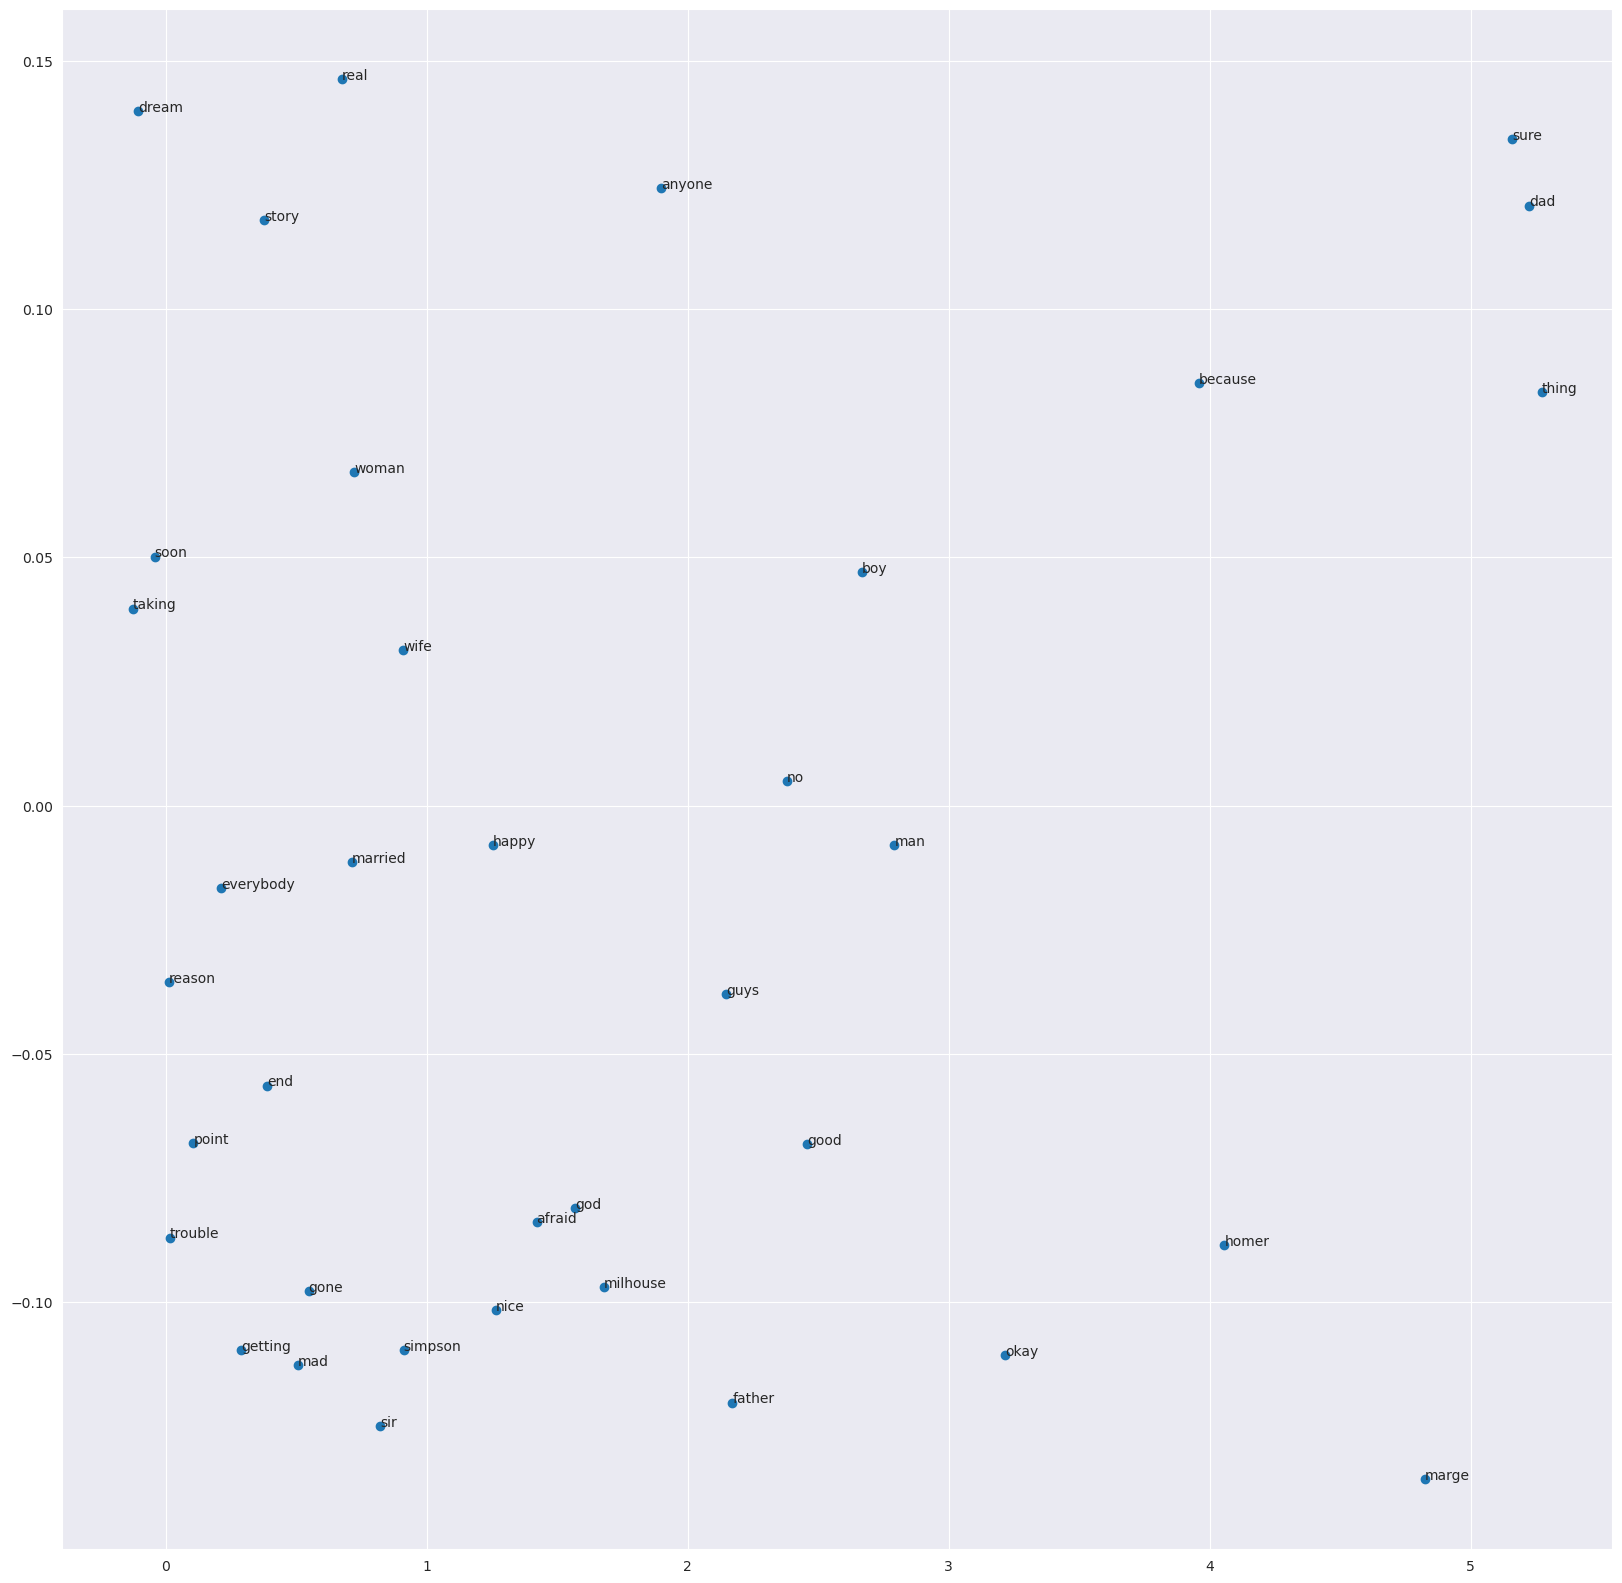

In [25]:
# фокус по центру

df_res = pd.DataFrame(res)
df_res['word'] = top_1000
min_, max_ = -0.15, 0.15
df_res_short = df_res[(df_res[0] > min_)&(df_res[1] > min_)&
                      (df_res[1] < max_)&(df_res[1] < max_)]

plt.scatter(df_res_short[0], df_res_short[1])
for i in range(len(df_res_short)):
    string = df_res_short.iloc[i,:]
    plt.annotate(string['word'], xy=(string[0], string[1]))
plt.gcf().set_size_inches(20, 20)

#### 2.2. Метод 2  / TSNE

In [26]:
cores     = multiprocessing.cpu_count()
sentences = data.spoken_words_corp

In [28]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [29]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [30]:
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, report_delay=1)

(12153756, 38754330)

In [31]:
w2v_model.init_sims(replace=True)

/tmp/ipykernel_637352/514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [40]:
def tsnescatterplot(model, word, list_names):

    arrays      = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    arrays      = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar([word])
    
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    reduc = PCA(n_components=10).fit_transform(arrays)
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]], 'y': [y for y in Y[:, 1]],
                       'words': word_labels, 'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    p1 = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o",
                     scatter_kws={'s': 40, 'facecolors': df['color']})
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],  df['y'][line], '  ' + df["words"][line].title(),
                 horizontalalignment='left', verticalalignment='bottom', 
                 size='medium', color=df['color'][line], weight='normal').set_size(15)
    
    plt.xlim(Y[:, 0].min()-20, Y[:, 0].max()+20)
    plt.ylim(Y[:, 1].min()-20, Y[:, 1].max()+20)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

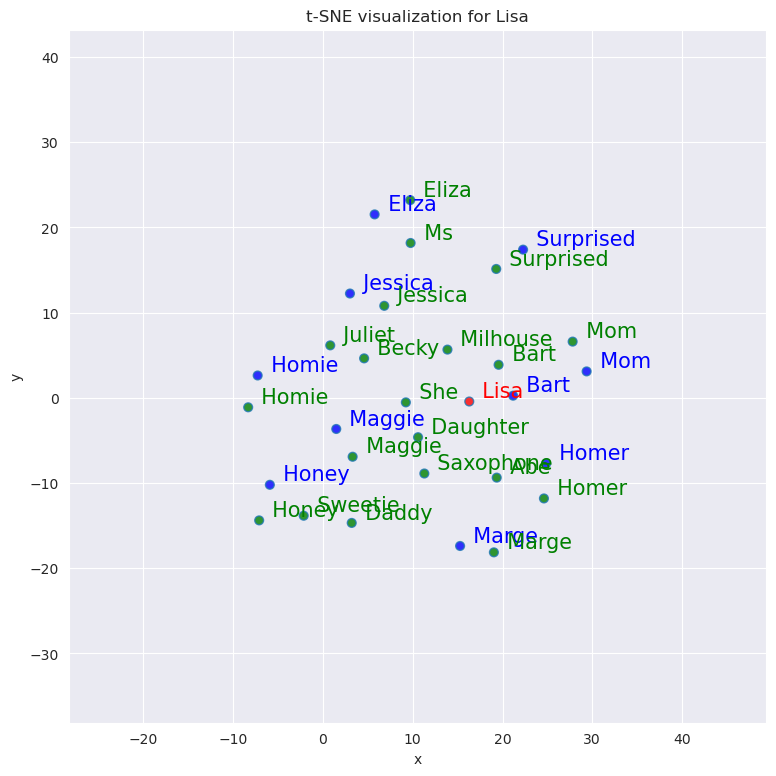

In [41]:
tsnescatterplot(w2v_model, 'lisa', 
                [i for (i,j) in w2v_model.wv.most_similar(positive=["lisa"], topn=20)])                

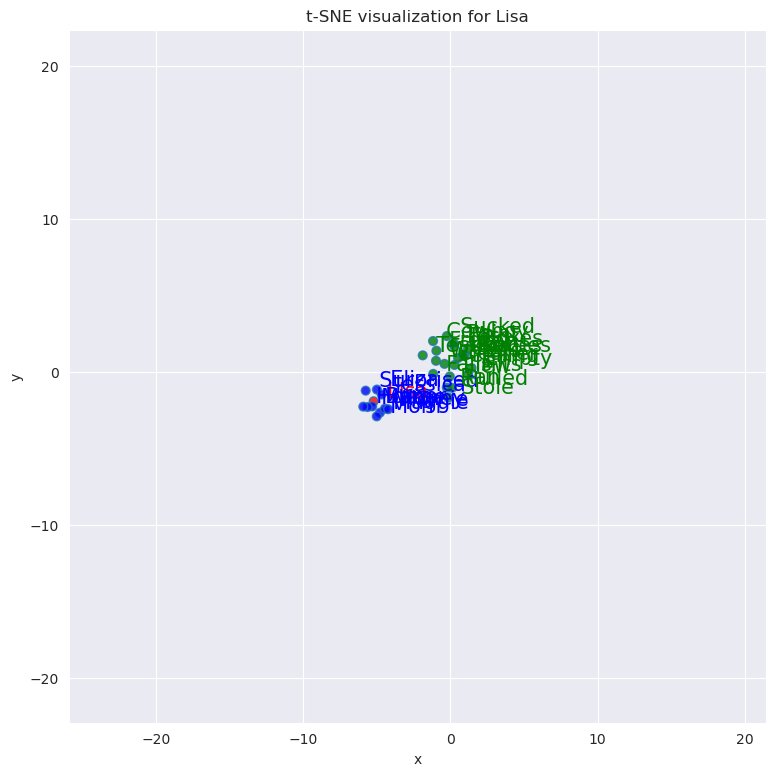

In [42]:
tsnescatterplot(w2v_model, 'lisa', 
                [i for (i,j) in w2v_model.wv.most_similar(negative=["lisa"], topn=20)])

### 3. Найти самые близкие слова для: 
- homer - marge + bart 
- bart - lisa + school 
- marge - homer + home

In [43]:
w2v_model.wv.most_similar(positive=["homer", "bart"], negative=["marge"], topn=5)

[('lisa', 0.43865469098091125),
 ('dad', 0.4098033905029297),
 ('simpson', 0.3919980823993683),
 ('mom', 0.31685757637023926),
 ('son', 0.2977774739265442)]

In [44]:
w2v_model.wv.most_similar(positive=["bart", "school"], negative=["lisa"], topn=5)

[('class', 0.33682680130004883),
 ('chalmers', 0.33329594135284424),
 ('brunch', 0.33238843083381653),
 ('prices', 0.314724862575531),
 ('noon', 0.3078143000602722)]

In [45]:
w2v_model.wv.most_similar(positive=["marge", "home"], negative=["homer"], topn=5)

[('back', 0.3388494849205017),
 ('someplace', 0.3243989050388336),
 ('anywhere', 0.31162407994270325),
 ('baby', 0.3045647144317627),
 ('near', 0.2987709641456604)]

In [46]:
w2v_model.wv.similarity("lisa", 'bart')

0.6420469

### 4. Построить и обучить классификатор  реплик Bart / Lisa

In [47]:
data = data.sample(frac=1).reset_index(drop=True)

In [48]:
sents = data.spoken_words_corp.tolist()
y     = data.class_L_B.values.tolist()

In [49]:
batch_size = 2000
sent_size  = 75
vec_size   = model.wv.get_vector('do').shape[0]
n_classes = len(set(y))

In [50]:
train = []
for i0, sent in enumerate(sents[:100000]):
    X = torch.zeros(sent_size, vec_size)
    for i1, word in enumerate(sent):
        r = torch.tensor(model.wv[word])
        X[i1] = r
    train.append((X.T, y[i0]))

test = []
for i0, sent in enumerate(sents[100000:]):
    X = torch.zeros(sent_size, vec_size)
    for i1, word in enumerate(sent):
        r = torch.tensor(model.wv[word])
        X[i1] = r
    test.append((X.T, y[i0 + 100000]))

In [51]:
data_train = DataLoader(train, batch_size = batch_size, shuffle=True)
data_test =  DataLoader(test, batch_size = batch_size, shuffle=True)

In [52]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm3 = nn.BatchNorm1d(32)
        self.norm2 = nn.BatchNorm1d(128)
        self.norm1 = nn.BatchNorm1d(512)
        self.l1    = nn.Linear(7500, 512)        
        self.l2    = nn.Linear(512, 128)
        self.l3    = nn.Linear(128, 32)
        self.l4    = nn.Linear(32, 3)
        self.drop  = nn.Dropout(0.2) 
        self.relu  = nn.ReLU()
        self.flat  = nn.Flatten()
    def forward(self, input):
        x = input
        x = self.flat(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.norm1(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.norm2(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.norm3(x)
        x = self.l4(x)
        return x

In [53]:
model1 = Net1().to(device)

In [54]:
optim = torch.optim.Adam(model1.parameters(), lr=0.00005)
crit  = torch.nn.CrossEntropyLoss()
n_iters = 30

for iter in range(n_iters):
    model1.train()
    for X, y in data_train:
        X, y = X.to(device), y.type(torch.LongTensor).to(device)        
        optim.zero_grad()
        pred = model1(X)
        loss = crit(pred, y)
        loss.backward()
        optim.step()
    train_score = torch.sum(torch.argmax(pred, axis=1) == y).item() / y.shape[0]

    model1.eval()
    for X, y in data_test:
        X, y = X.to(device), y.type(torch.LongTensor).to(device)
        pred = model1(X)
        test_score = torch.sum(torch.argmax(pred, axis=1) == y).item() / y.shape[0]
        print(f'iter {iter}, loss = {loss}, train score = {train_score}, test score = {test_score}')
        break

iter 0, loss = 1.111375093460083, train score = 0.376, test score = 0.4945
iter 1, loss = 1.0738937854766846, train score = 0.4275, test score = 0.501
iter 2, loss = 1.0660420656204224, train score = 0.445, test score = 0.537
iter 3, loss = 1.0410656929016113, train score = 0.473, test score = 0.598
iter 4, loss = 1.0318266153335571, train score = 0.506, test score = 0.609
iter 5, loss = 1.0286777019500732, train score = 0.5045, test score = 0.6335
iter 6, loss = 1.0108002424240112, train score = 0.535, test score = 0.655
iter 7, loss = 0.9851852655410767, train score = 0.571, test score = 0.683
iter 8, loss = 0.9531498551368713, train score = 0.6145, test score = 0.7355
iter 9, loss = 0.9490535855293274, train score = 0.643, test score = 0.719
iter 10, loss = 0.9192366600036621, train score = 0.685, test score = 0.751
iter 11, loss = 0.9055332541465759, train score = 0.6745, test score = 0.745
iter 12, loss = 0.864277720451355, train score = 0.7355, test score = 0.7605
iter 13, loss =